<a href="https://colab.research.google.com/github/astrodatos/proyecto_neuralclusters/blob/master/Neural_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se predecirá la temperatura efectiva de una estrella a través de sus magnitudes absolutas en cinco bandas fotométricas (problema de regresión). Se ha utilizado la base de datos del SDSS, consultando el mismo a través de astroquery.

In [1]:
!pip install --pre --quiet astroquery

     |████████████████████████████████| 4.3MB 3.4MB/s 
     |████████████████████████████████| 2.3MB 32.1MB/s 
     |████████████████████████████████| 61kB 24.2MB/s 
     |████████████████████████████████| 102kB 32.4MB/s 


In [69]:
from __future__ import absolute_import, division, print_function, unicode_literals

from time import time
from astroquery.sdss import SDSS

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


print(tf.__version__)

1.14.0-rc1


## Datos del SDSS

Disponible en enlace
### Consulta con astroquery



In [0]:
t_ini = time()

data = SDSS.query_sql("""SELECT TOP 5000
                      p.fiberMag_u, p.fiberMag_g, p.fiberMag_r, p.fiberMag_i, 
                      p.fiberMag_z,s.elodieTEff
                   
                      
                      FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
                      
                      WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO' AND s.class !='GALAXY'
                      
                      """)

In [161]:
datapd=data.to_pandas()
print(datapd)

      fiberMag_u  fiberMag_g  fiberMag_r  fiberMag_i  fiberMag_z  elodieTEff
0       19.97522    18.29667    17.63645    17.41323    17.28637        5059
1       18.54812    17.42075    16.99692    16.81944    16.74287        5720
2       18.92459    17.60666    17.11381    16.92150    16.82598        5467
3       20.52509    18.30592    17.47765    17.19801    17.04544        4775
4       19.01954    17.86671    17.52623    17.40356    17.30230        6162
5       21.77839    18.90348    17.48030    16.04839    15.14471        3717
6       19.60481    17.88959    17.24570    17.03980    16.81905        5059
7       22.02673    19.01092    17.56478    16.65598    16.03874        3980
8       19.65194    18.38753    18.03152    17.92039    17.78299        6038
9       21.44282    18.97859    17.92464    17.44443    17.08808        4382
10      20.45667    18.36052    17.55198    17.28331    17.02710        4576
11      21.36427    18.87977    17.85104    17.38925    17.10785        4382

### Separación entre datos de entrenamiento y datos de prueba 

In [0]:
train_datapd = datapd.sample(frac=0.8,random_state=0)
test_datapd = datapd.drop(train_datapd.index)


### Chequeo a los datos

Estadísticas:

In [163]:
train_stats = train_datapd.describe()
train_stats.pop("elodieTEff")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
fiberMag_u,4000.0,18.031618,158.437985,-9999.00000,18.921820,20.107020,22.036257,26.29402
fiberMag_g,4000.0,16.699372,158.414264,-9999.00000,17.807730,18.869925,20.299855,26.15056
fiberMag_r,4000.0,18.582139,1.695386,13.08655,17.338203,18.344810,19.764685,23.61842
fiberMag_i,4000.0,15.644923,158.391732,-9999.00000,17.014040,18.074505,19.300670,23.00798
fiberMag_z,4000.0,15.414419,158.388190,-9999.00000,16.846360,17.820725,18.824245,22.68608


### Separacaión entre atributos y etiquetas

En este caso, la temperatura es la etiqueta, mientras que los atributos son las magnitudes absolutas en cinco bandas fotométricas.

In [0]:
train_labels = train_datapd.pop('elodieTEff')
test_labels = test_datapd.pop('elodieTEff')

train_feat = train_datapd
test_feat = test_datapd


### Normalización de los datos


In [0]:
#norm train label
def norm(x):
  r=(x-x.mean())/x.std()
  return r

In [166]:

#normtest_temp=tf.keras.utils.normalize(test_labels,axis=0)
train_mean=train_labels.mean()
train_std=train_labels.std()


norm_train_labels=(train_labels-train_mean)/train_std
norm_train_feat = (train_feat - train_feat.mean())/train_feat.std()
print(norm_train_labels)

398    -0.464921
3833   -1.189049
4836    1.901073
4572   -1.189049
636    -1.106576
2545    0.290208
1161   -0.800079
2230   -1.193144
148     1.901073
2530    0.146319
4070   -1.189049
1261   -0.026817
4682   -0.464921
333    -0.800079
906    -1.106576
3170    0.146319
483    -0.438600
2825    1.608614
1778    1.229587
2466    1.023696
159    -1.189049
1563   -1.189049
402     1.023696
4258   -0.800079
4775   -0.160179
1095   -0.800079
3054   -1.189049
4268   -1.190804
3711    1.112603
453    -1.045745
          ...   
4198    0.146319
1534    0.146319
2336    0.731237
3946   -1.189049
3850   -0.800079
3492    0.146319
2305    0.146319
960    -0.822891
3313    2.426914
1164    1.023696
371    -0.800079
1306   -1.189049
2993   -1.189049
4145    1.129566
3541    1.023696
1575    0.062675
3742    0.146319
1484    2.193532
3834   -1.189049
2548   -1.190804
4749   -1.189049
1858   -0.686605
258    -0.101687
3835   -1.189049
769    -0.271898
2061   -1.189049
4211    1.023696
2018   -1.1065

Se utilizarán los datos normalizados para entrenar el modelo.


## El modelo

### Estructura de la red neuronal

Modelo Secuencial

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(1, activation=tf.nn.tanh, input_shape=[len(train_datapd.keys())]),
    #layers.Dense(5, activation=tf.nn.tanh),
    #layers.Dense(4, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

### Inspección del modelo

In [168]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1)                 6         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 2         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento del modelo

In [169]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  norm_train_feat, norm_train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [0]:
def desnorm(dato, media, std):
  datonuevo = dato*std + media
  return datonuevo
  

Visualize the model's training progress using the stats stored in the `history` object.

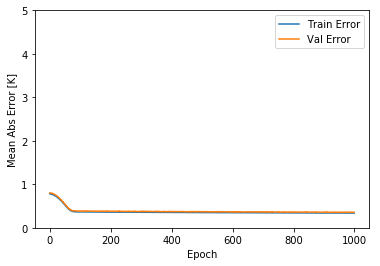

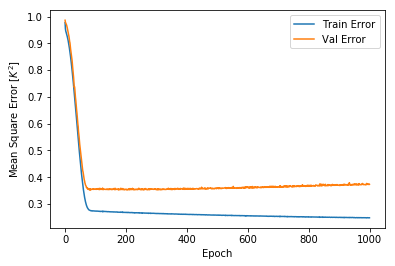

In [171]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

print(history)

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [K]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$K^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [0]:
#model = build_model()

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#history = model.fit(norm_train_feat, train_labels, epochs=EPOCHS,
#                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
#print(history)
#plot_history(history)

In [173]:
norm_test_feat = (test_feat-test_feat.mean())/test_feat.std()
norm_test_labels = (test_labels-test_labels.mean())/test_labels.std()


loss, mae, mse = model.evaluate(norm_test_feat, norm_test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Abs Error:  8.11


### Make predictions

Finally, predict Temperature values using data in the testing set:

(-625.0, 31467.558282888378, -7486.743008631691, 24605.81527425669)

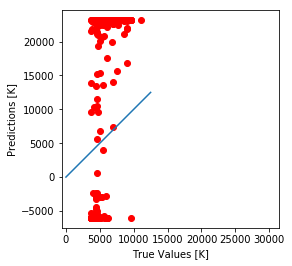

In [174]:
#print(norm_test_labels)

test_predictions = model.predict(norm_test_feat).flatten()
#print(test_predictions)

test_predictions = desnorm(test_predictions, train_mean, train_std)

plt.scatter(test_labels, test_predictions, color='red')
plt.plot([0 , 12500], [0, 12500])
plt.xlabel('True Values [K]')
plt.ylabel('Predictions [K]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,100])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])

It looks like our model predicts reasonably well. Let's take a look at the error distribution.

245.32165002822876


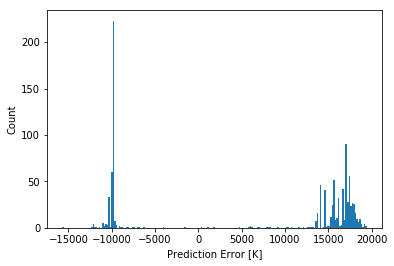

In [175]:
error = test_predictions - test_labels
plt.hist(error, bins = 200)
plt.xlabel("Prediction Error [K]")
_ = plt.ylabel("Count")

t_fin = time()

print(t_fin - t_ini)